# SVM (Support Vector Machines)

In this notebook, I have used SVM to build and train a model using human cell records and classify cells to whether the samples are benign or malignant.

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

## Importing necessary libraries

In [2]:
import numpy as np
import pandas as pd
import pylab as pl
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

## Load the Cancer data
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007).

The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

| Field name  | Description                 |
| ----------- | --------------------------- |
| ID          | Clump thickness             |
| Clump       | Clump thickness             |
| UnifSize    | Uniformity of cell size     |
| UnifShape   | Uniformity of cell shape    |
| MargAdh     | Marginal adhesion           |
| SingEpiSize | Single epithelial cell size |
| BareNuc     | Bare nuclei                 |
| BlandChrom  | Bland chromatin             |
| NormNucl    | Normal nucleoli             |
| Mit         | Mitoses                     |
| Class       | Benign or malignant         |

<br>
<br>

For the purposes of this example, we're using a dataset that has a relatively small number of predictors in each record.

## Loading and reading the dataset

In [3]:
df = pd.read_csv('cell_samples.csv')

In [4]:
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [5]:
df.tail()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4
698,897471,4,8,8,5,4,5,10,4,1,4


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

**Let's look at the distribution of the classes based on Clump thickness and Uniformity of cell size:**

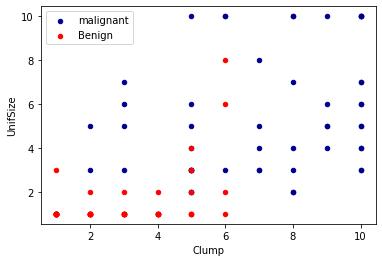

In [7]:
ax1 = df[df['Class']==4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
df[df['Class']==2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Red', label='Benign', ax=ax1);
plt.show()


## Data pre-processing and selection
Let's first look at columns data types:

In [8]:
df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

It looks like the **BareNuc** column includes some values that are not numerical. Let's convert it to int:

In [9]:
df = df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]
df['BareNuc'] = df['BareNuc'].astype('int')
df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ID           683 non-null    int64
 1   Clump        683 non-null    int64
 2   UnifSize     683 non-null    int64
 3   UnifShape    683 non-null    int64
 4   MargAdh      683 non-null    int64
 5   SingEpiSize  683 non-null    int64
 6   BareNuc      683 non-null    int32
 7   BlandChrom   683 non-null    int64
 8   NormNucl     683 non-null    int64
 9   Mit          683 non-null    int64
 10  Class        683 non-null    int64
dtypes: int32(1), int64(10)
memory usage: 61.4 KB


In [12]:
feature_df = df[['Clump','UnifSize','UnifShape','MargAdh','SingEpiSize','BareNuc','BlandChrom','NormNucl','Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

We want the model to predict the value of Class (i.e , benign=2 and malignant=4). As the field can have one of only two possible values, we need to change its measurement level to reflect this.

In [15]:
df['Class'] = df['Class'].astype('int')
y = np.asarray(df['Class'])
y[0:10]

array([2, 2, 2, 2, 2, 4, 2, 2, 2, 2])

## Train/Test dataset
We split our dataset into train and test set.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [17]:
X_train.shape

(546, 9)

In [18]:
X_test.shape

(137, 9)

In [19]:
y_train.shape

(546,)

In [20]:
y_test.shape

(137,)

## Modeling (SVM with scikit-learn)

The SVM algorithm offers a choice of kernel functions for performing its processing.Basically mapping data into a higher dimensional space is called kerneling. The mathematical function used for the transformation is known as kernel function, and can be of different types such as:
- Linear
- Polynomial
- Radial basis function(RBF)
- Sigmoid

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset. We usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for now.

In [21]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

After being fitted, model can be used to predict new values.

In [22]:
pred = clf.predict(X_test)
pred[0:5]

array([2, 4, 2, 4, 2])

## Evaluation

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [26]:
def plot_confusion_matrix(cm,classes,
                          normalize='False',
                          title='Confusion matrix',
                          cmap=plt.cm.Blues
                          ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')  

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix without normalization
[[85  5]
 [ 0 47]]


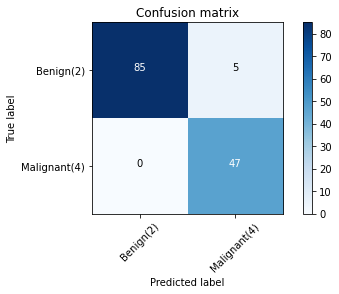

In [27]:
#compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred, labels=[2,4])
np.set_printoptions(precision=2)

print(classification_report(y_test,pred))

#plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)', 'Malignant(4)'], normalize=False, title='Confusion matrix')

**You can also use f1_score from sklearn library:**
    

In [29]:
from sklearn.metrics import f1_score
f1_score(y_test, pred, average='weighted')

0.9639038982104676

**Let's try jaccard index for accuracy**

In [30]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, pred, pos_label=2)

0.9444444444444444

### Practice
Can you rebuild the model, but this time with a __linear__ kernel? You can use __kernel='linear'__ option, when you define the svm. How the accuracy changes with the new kernel function?

In [31]:
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train)
pred_ = clf2.predict(X_test)

In [32]:
f1_score(y_test, pred_, average='weighted')

0.9639038982104676

In [33]:
jaccard_score(y_test, pred_, pos_label=2)

0.9444444444444444

# The End